In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#218670687
#Chakela SM
import librosa
from scipy import signal

import IPython.display as ipd

import numpy as np

import matplotlib.pyplot as plt


In [3]:
!unzip /content/drive/MyDrive/audio.zip

Archive:  /content/drive/MyDrive/audio.zip
  inflating: non emergency.wav       
  inflating: __MACOSX/._non emergency.wav  
  inflating: emergency.wav           
  inflating: __MACOSX/._emergency.wav  


In [4]:
path='emergency.wav'
emergency,sample_rate = librosa.load(path, sr =16000)

path='non emergency.wav'
non_emergency,sample_rate = librosa.load(path, sr =16000)

In [5]:
duration1 = librosa.get_duration(emergency,sr=16000)
duration2 = librosa.get_duration(non_emergency,sr=16000)

print("Duration of ana emergrncy and Non emergency (in min):",duration1/60,duration2/60)

Duration of ana emergrncy and Non emergency (in min): 22.920290625 27.160834375


**Preparing** **Data**

In [6]:
def prepare_data(samples,num_of_samples=32000, num_of_common=16000):

  data=[]
  for offset in range(0,len(samples), num_of_common):
    start = offset
    end = offset + num_of_samples
    chunk = samples[start:end]

    if(len(chunk)==32000):
      data.append(chunk)

  return data 
 

**Call** **the** **above** **function** 

In [7]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

print("No. of chunks of emergency and non emergency:",len(emergency),len(non_emergency))

No. of chunks of emergency and non emergency: 1374 1628


In [8]:
ipd.Audio(emergency[100],rate=16000)

In [9]:
ipd.Audio(emergency[136],rate=16000)

In [10]:
ipd.Audio(non_emergency[10],rate=16000)

In [11]:
ipd.Audio(emergency[200],rate=16000)

Text(0, 0.5, 'Amplitude')

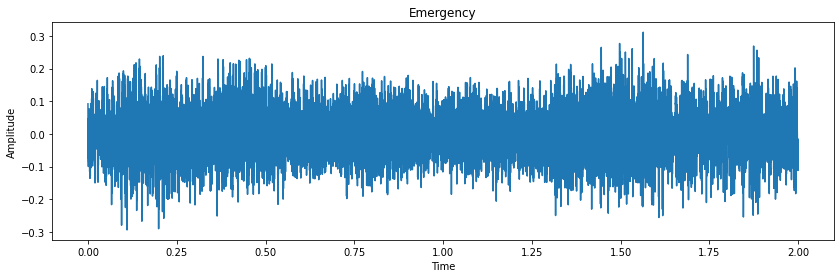

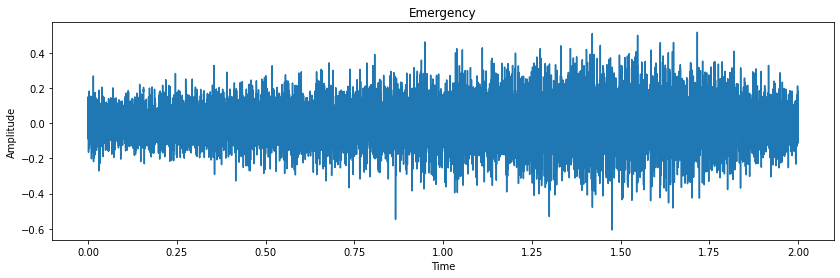

In [12]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [13]:
audio = np.concatenate([emergency,non_emergency])

In [14]:
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

labels = np.concatenate([labels1,labels2])

In [15]:
print(audio.shape)

(3002, 32000)


**Split** **into** **train** **and** **validation** **set**

In [16]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),stratify=labels,test_size=0.1,random_state=777,shuffle=True)

In [17]:
x_tr_features = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshape Array Size",x_tr_features.shape)


Reshape Array Size (2701, 32000, 1)


**Model** **Architecture**

In [18]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as k

def conv1d(x_tr):
  k.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  conv=Conv1D(8,13, padding='same', activation='relu')(inputs)
  conv=Dropout(0.3)(conv)
  conv=MaxPooling1D(2)(conv)

  conv=GlobalMaxPool1D()(conv)

  conv=Dense(16, activation='relu')(conv)
  outputs=Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5',monitor='val_acc',verbose=1,save_best_only=True,mode='max')

  return model,model_checkpoint


**Define** **the** **model**

In [19]:
model,model_checkpoint = conv1d(x_tr_features)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16000, 8)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 8)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                144   

In [21]:
history=model.fit(x_tr_features,y_tr,epochs=10,callbacks=[model_checkpoint],batch_size=32,validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6780 - acc: 0.6638
Epoch 1: val_acc improved from -inf to 0.75083, saving model to best_model.hdf5
85/85 [==============================] - 36s 414ms/step - loss: 0.6780 - acc: 0.6638 - val_loss: 0.6676 - val_acc: 0.7508
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.6370 - acc: 0.7642
Epoch 2: val_acc improved from 0.75083 to 0.77741, saving model to best_model.hdf5
85/85 [==============================] - 35s 415ms/step - loss: 0.6370 - acc: 0.7642 - val_loss: 0.6359 - val_acc: 0.7774
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.5912 - acc: 0.7701
Epoch 3: val_acc did not improve from 0.77741
85/85 [==============================] - 35s 414ms/step - loss: 0.5912 - acc: 0.7701 - val_loss: 0.5986 - val_acc: 0.7774
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.5528 - acc: 0.7712
Epoch 4: val_acc did not improve from 0.77741
85/85 [================

**Load** **the** **best** **model**

In [22]:
model.load_weights('best_model.hdf5')

In [23]:
_, acc = model.evaluate(x_val_features,y_val)
print('Validation Accuracy:',acc)

10/10 [==============================] - 1s 119ms/step - loss: 0.6359 - acc: 0.7774
Validation Accuracy: 0.7774086594581604


**Inference**

In [24]:
ind = 35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [25]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if(prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency'

  print("prediction:",pred)

1/1 [==============================] - 0s 113ms/step
prediction: non emergency


In [26]:
x_tr_features = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [27]:
def lstm(x_tr):
  k.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  x= LSTM(128)(inputs)
  x= Dropout(0.3)(x)

  X=Dense(64,activation='relu')(x)
  x=Dense(1,activation='sigmoid')(x)

  model = Model(inputs, x)

  model.compile(loss='[binary_crossentropy',optimizer='adam',metrics=['acc'])

  return model


In [28]:
model = lstm(x_tr_features)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 148,097
Trainable params: 148,097
Non-trainable params: 0
_________________________________________________________________


In [30]:
#mc =ModelCheckpoint('best_model.hdf5',monitor='val_acc',verbose=1,save_best_only=True,mode=max)

In [65]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[model_checkpoint], batch_size=32, validation_data=(x_val_features, y_val))

Epoch 1/10
84/85 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9993
Epoch 1: val_acc did not improve from 0.97674
85/85 [==============================] - 8s 90ms/step - loss: 0.0090 - acc: 0.9989 - val_loss: 0.0939 - val_acc: 0.9668
Epoch 2/10
84/85 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9989
Epoch 2: val_acc did not improve from 0.97674
85/85 [==============================] - 6s 68ms/step - loss: 0.0075 - acc: 0.9989 - val_loss: 0.0838 - val_acc: 0.9601
Epoch 3/10
84/85 [============================>.] - ETA: 0s - loss: 0.0054 - acc: 0.9989
Epoch 3: val_acc did not improve from 0.97674
85/85 [==============================] - 6s 68ms/step - loss: 0.0054 - acc: 0.9989 - val_loss: 0.0713 - val_acc: 0.9767
Epoch 4/10
84/85 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.9996
Epoch 4: val_acc did not improve from 0.97674
85/85 [==============================] - 6s 68ms/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.068

In [66]:
model.load_weights('best_model.hdf5')

In [67]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 0s 14ms/step - loss: 0.0534 - acc: 0.9867
Accuracy: 0.9867109656333923


In [36]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [37]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if(prob[0][0] < 0.5):
  pred='emergrncy'
else:
   pred='non_emergency'
print("Prediction:",pred)  


1/1 [==============================] - 0s 466ms/step
Prediction: emergrncy


**Spectrogram**

In [38]:
def log_specgram(audio, sample_rate, eps=1e-10):
  nperseg = 320
  noverlap = 160
  freqs, times, spec = signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg, noverlap=noverlap, detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32)+eps)

**Defi**ne **a** **function** **for** **representing** **spectrogram**

In [43]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14,8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', orign='lower', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_tittle('Spectrogram of '+ label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabels('Seconds')

**Compute** **the** **spectrogram**

AttributeError: ignored

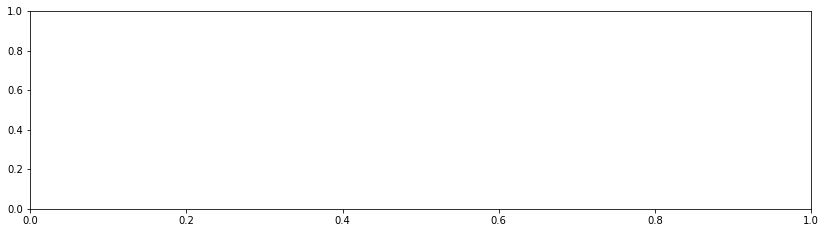

In [69]:
freqs, times, spectrogram = log_specgram(emergency[300],sample_rate)
plot(spectrogram, "emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300],sample_rate)
plot(spectrogram,"non_emergency")

In [45]:
spectrogram.shape

(199, 161)

**Extract** **the** **spectogram** **features**

In [50]:
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram =log_specgram(i, sample_rate)

    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std

    features.append(spectrogram)

  return np.array(features) 

In [51]:
x_tr_features = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

**Define** **architecture**

In [52]:
def lstm(x_tr):
  k.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)

  model = Model(inputs , x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

  mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

  return model,mc

**Define** **the** **model**:

In [71]:
model, mc = lstm(x_tr_features)

UnboundLocalError: ignored

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 148,097
Trainable params: 148,097
Non-trainable params: 0
_________________________________________________________________


**Train** **the** **model**

In [64]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[model_checkpoint], batch_size=32, validation_data=(x_val_features, y_val))

Epoch 1/10
84/85 [============================>.] - ETA: 0s - loss: 0.7011 - acc: 0.6458
Epoch 1: val_acc improved from 0.77741 to 0.78738, saving model to best_model.hdf5
85/85 [==============================] - 7s 69ms/step - loss: 0.7001 - acc: 0.6472 - val_loss: 0.5442 - val_acc: 0.7874
Epoch 2/10
84/85 [============================>.] - ETA: 0s - loss: 0.3477 - acc: 0.8624
Epoch 2: val_acc improved from 0.78738 to 0.91362, saving model to best_model.hdf5
85/85 [==============================] - 6s 67ms/step - loss: 0.3473 - acc: 0.8623 - val_loss: 0.2959 - val_acc: 0.9136
Epoch 3/10
84/85 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9650
Epoch 3: val_acc improved from 0.91362 to 0.94020, saving model to best_model.hdf5
85/85 [==============================] - 6s 68ms/step - loss: 0.1427 - acc: 0.9652 - val_loss: 0.1989 - val_acc: 0.9402
Epoch 4/10
84/85 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9870
Epoch 4: val_acc improved from 0.94

**load** **the** **weights** **of** **the** **best** **model**

In [72]:
model.load_weights('best_model.hdf5')

In [73]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy",acc)

10/10 [==============================] - 0s 14ms/step - loss: 0.0534 - acc: 0.9867
Accuracy 0.9867109656333923


In [58]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [63]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if(prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency'

  print("prediction:",pred)  

1/1 [==============================] - 0s 66ms/step
prediction: non emergency


In [60]:
model, mc =conv1d(x_tr_features)

In [61]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 conv1d (Conv1D)             (None, 199, 8)            16752     
                                                                 
 dropout (Dropout)           (None, 199, 8)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 99, 8)            0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 8)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                144   